In [49]:
# pip install yfinance numpy pandas matplotlib scipy

In [73]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the expanded list of 50 US stocks and the benchmark
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 
          'XOM', 'BAC', 'KO', 'DIS', 'PFE', 'CSCO', 'NFLX', 'BA', 'NKE', 'C',
          'INTC', 'IBM', 'NVDA', 'ADBE', 'PYPL', 'MA', 'MRK', 'PEP', 'MCD', 'ABT', 
          'CRM', 'ORCL', 'CVX', 'T', 'MDT', 'HON', 'GE', 'MMM', 'CAT', 'LOW',
          'LMT', 'UNH', 'HD', 'TXN', 'GS', 'AXP', 'SBUX', 'UPS', 'FDX', 'TGT']
benchmark = '^GSPC'  # S&P 500 index

# Set the time period for the last 10 years
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download stock data
stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
benchmark_data = yf.download(benchmark, start=start_date, end=end_date)['Adj Close']

# Show the first few rows of the downloaded data
print(stock_data.head())
print(benchmark_data.head())


[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


Ticker                          AAPL        ABT       ADBE       AMZN  \
Date                                                                    
2014-01-02 00:00:00+00:00  17.253260  30.904152  59.290001  19.898500   
2014-01-03 00:00:00+00:00  16.874273  31.235575  59.160000  19.822001   
2014-01-06 00:00:00+00:00  16.966295  31.647869  58.119999  19.681499   
2014-01-07 00:00:00+00:00  16.844952  31.405348  58.970001  19.901501   
2014-01-08 00:00:00+00:00  16.951632  31.688269  58.900002  20.096001   

Ticker                           AXP          BA        BAC          C  \
Date                                                                     
2014-01-02 00:00:00+00:00  76.407578  116.807938  13.049140  40.333008   
2014-01-03 00:00:00+00:00  76.655273  117.619934  13.300398  41.204948   
2014-01-06 00:00:00+00:00  76.621132  118.295044  13.503027  41.521324   
2014-01-07 00:00:00+00:00  76.330688  120.089890  13.373341  41.806816   
2014-01-08 00:00:00+00:00  76.570457  120.35

In [74]:
# Calculate daily returns for the stocks and benchmark
daily_returns = stock_data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Annualized return and volatility (standard deviation)
annualized_returns = daily_returns.mean() * 252  # Annualized return
annualized_volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

# Annualized return and volatility for the benchmark
benchmark_annualized_return = benchmark_returns.mean() * 252
benchmark_annualized_volatility = benchmark_returns.std() * np.sqrt(252)

# Show the first few rows of daily returns and annualized stats
print("Daily Returns (First Few Rows):")
print(daily_returns.head())

print("\nAnnualized Returns:")
print(annualized_returns)

print("\nAnnualized Volatility (Standard Deviation):")
print(annualized_volatility)

print("\nBenchmark Annualized Return and Volatility:")
print(benchmark_annualized_return, benchmark_annualized_volatility)


Daily Returns (First Few Rows):
Ticker                         AAPL       ABT      ADBE      AMZN       AXP  \
Date                                                                          
2015-07-07 00:00:00+00:00 -0.002460  0.009449  0.001118  0.001560 -0.000515   
2015-07-08 00:00:00+00:00 -0.024823 -0.019120 -0.007445 -0.016074 -0.020889   
2015-07-09 00:00:00+00:00 -0.020397 -0.001218  0.006001  0.010915  0.005400   
2015-07-10 00:00:00+00:00  0.026734  0.015043  0.001491  0.020995  0.012706   
2015-07-13 00:00:00+00:00  0.019306  0.000604  0.010547  0.027192  0.015781   

Ticker                           BA       BAC         C       CAT       CRM  \
Date                                                                          
2015-07-07 00:00:00+00:00  0.018716 -0.014758 -0.010530  0.010102  0.015905   
2015-07-08 00:00:00+00:00 -0.008592 -0.026363 -0.031193 -0.020479 -0.012383   
2015-07-09 00:00:00+00:00  0.006201  0.014154  0.017235 -0.007050  0.008214   
2015-07-10 00:00:00

In [75]:
from scipy.optimize import minimize

# Function to calculate portfolio performance (returns and volatility)
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.sum(weights * returns)  # Portfolio return
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility
    return port_return, port_volatility

# Function to generate random portfolios (for Efficient Frontier)
def generate_random_portfolios(num_portfolios, returns, cov_matrix):
    results = np.zeros((3, num_portfolios))  # Return, volatility, Sharpe ratio
    weights_array = []
    
    for _ in range(num_portfolios):
        weights = np.random.random(len(returns))
        weights /= np.sum(weights)  # Normalize to sum to 1
        weights_array.append(weights)
        
        port_return, port_volatility = portfolio_performance(weights, returns, cov_matrix)
        sharpe_ratio = port_return / port_volatility
        
        results[0, _] = port_return
        results[1, _] = port_volatility
        results[2, _] = sharpe_ratio
    
    return results, weights_array

# Function to minimize portfolio volatility (for Min Variance Portfolio)
def minimize_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate the negative Sharpe Ratio (for Tangency Portfolio)
def negative_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    port_return, port_volatility = portfolio_performance(weights, returns, cov_matrix)
    return -(port_return - risk_free_rate) / port_volatility

# Constraints: sum of weights must be 1
def weights_constraint(weights):
    return np.sum(weights) - 1

# Bounds: weights must be between 0 and 1 (no short selling)
bounds = tuple((0, 1) for _ in range(len(annualized_returns)))

# Risk-free rate assumption (typically close to zero in recent years)
risk_free_rate = 0.03


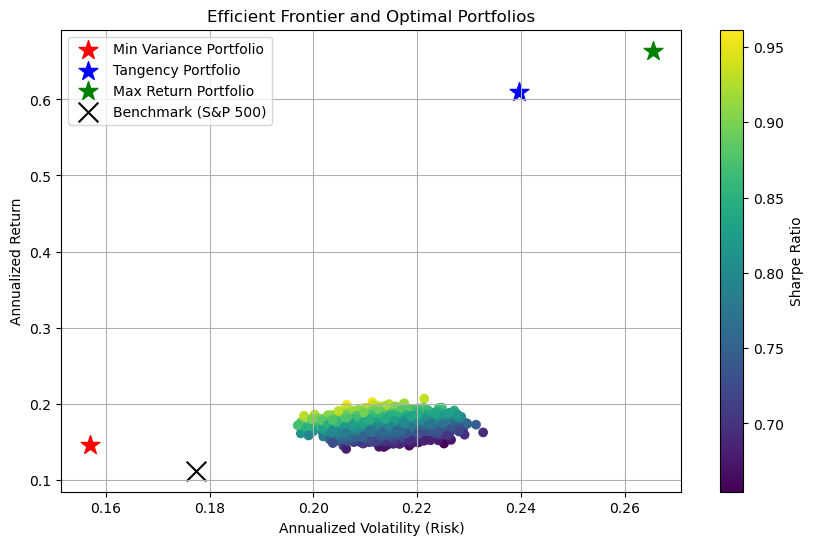

In [95]:
# Exclude the benchmark from the stock returns to calculate the covariance matrix
cov_matrix = daily_returns[stocks].cov() * 252  # Annualized covariance matrix

# Initial guess for weights (evenly distributed across the stocks)
initial_weights = np.array([1 / len(stocks)] * len(stocks))

# Minimize volatility (Minimum Variance Portfolio)
min_variance_result = minimize(minimize_volatility, initial_weights, args=cov_matrix, 
                               method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': weights_constraint})

# Maximize Sharpe ratio (Tangency Portfolio)
tangency_result = minimize(negative_sharpe_ratio, initial_weights, args=(annualized_returns, cov_matrix, risk_free_rate),
                           method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': weights_constraint})

# Max return portfolio (the stock with the highest return)
max_return_weights = np.zeros(len(annualized_returns))
max_return_weights[np.argmax(annualized_returns)] = 1  # Assign all weight to the stock with the max return

# Extract portfolio stats (returns, volatilities) for each portfolio
min_var_return, min_var_volatility = portfolio_performance(min_variance_result.x, annualized_returns, cov_matrix)
tangency_return, tangency_volatility = portfolio_performance(tangency_result.x, annualized_returns, cov_matrix)
max_return_return, max_return_volatility = portfolio_performance(max_return_weights, annualized_returns, cov_matrix)

# Increase the number of random portfolios
num_portfolios = 5000

# Generate random portfolios for the Efficient Frontier
random_portfolios, random_weights = generate_random_portfolios(num_portfolios, annualized_returns, cov_matrix)

# Plot the Efficient Frontier and optimal portfolios
plt.figure(figsize=(10, 6))
plt.scatter(random_portfolios[1,:], random_portfolios[0,:], c=random_portfolios[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')

# Plot the key portfolios
plt.scatter(min_var_volatility, min_var_return, color='red', marker='*', s=200, label='Min Variance Portfolio')
plt.scatter(tangency_volatility, tangency_return, color='blue', marker='*', s=200, label='Tangency Portfolio')
plt.scatter(max_return_volatility, max_return_return, color='green', marker='*', s=200, label='Max Return Portfolio')

# Plot the benchmark (S&P 500)
plt.scatter(benchmark_annualized_volatility, benchmark_annualized_return, color='black', marker='x', s=200, label='Benchmark (S&P 500)')

# Labels and title
plt.title('Efficient Frontier and Optimal Portfolios')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

plt.show()

In [96]:
# Align all weights with the full list of stocks to ensure the same length for each portfolio
min_var_weights_series = pd.Series(min_var_weights, index=stocks).fillna(0)
tangency_weights_series = pd.Series(tangency_weights, index=stocks).fillna(0)
max_return_weights_series = pd.Series(max_return_weights, index=stocks).fillna(0)

# Create a DataFrame to store the results for the key portfolios
portfolio_stats = pd.DataFrame({
    'Asset': stocks,
    'Min Variance Weights': min_var_weights_series.values,
    'Tangency Weights': tangency_weights_series.values,
    'Max Return Weights': max_return_weights_series.values,
})

# Assuming you have already calculated the following values for the portfolios:
min_var_sharpe = min_var_return / min_var_volatility
tangency_sharpe = tangency_return / tangency_volatility
max_return_sharpe = max_return_return / max_return_volatility

# Create a row for the portfolio-level statistics (returns, volatilities, and sharpe ratios)
portfolio_stats_summary = pd.DataFrame({
    'Asset': ['Portfolio Stats'],
    'Min Variance Weights': [f'Return: {min_var_return:.4f}, Volatility: {min_var_volatility:.4f}, Sharpe: {min_var_sharpe:.4f}'],
    'Tangency Weights': [f'Return: {tangency_return:.4f}, Volatility: {tangency_volatility:.4f}, Sharpe: {tangency_sharpe:.4f}'],
    'Max Return Weights': [f'Return: {max_return_return:.4f}, Volatility: {max_return_volatility:.4f}, Sharpe: {max_return_sharpe:.4f}']
})

# Concatenate the original DataFrame with the summary row
final_table = pd.concat([portfolio_stats, portfolio_stats_summary], ignore_index=True)

# Display the final table for better clarity
print(final_table)

# Generate LaTeX format for saving
latex_output = final_table.to_latex(index=False)

# Save the LaTeX to a file
with open("portfolio_stats_table.tex", "w") as f:
    f.write(latex_output)

print("LaTeX file has been saved as 'portfolio_stats_table.tex'")


              Asset                               Min Variance Weights  \
0              AAPL                                                0.0   
1              MSFT                                             0.0355   
2             GOOGL                                                0.0   
3              AMZN                                                0.0   
4              TSLA                                                0.0   
5               JPM                                                0.0   
6                 V                                             0.0227   
7               JNJ                                                0.0   
8               WMT                                             0.2179   
9                PG                                                0.0   
10              XOM                                             0.2209   
11              BAC                                                0.0   
12               KO                   

[*********************100%***********************]  51 of 51 completed


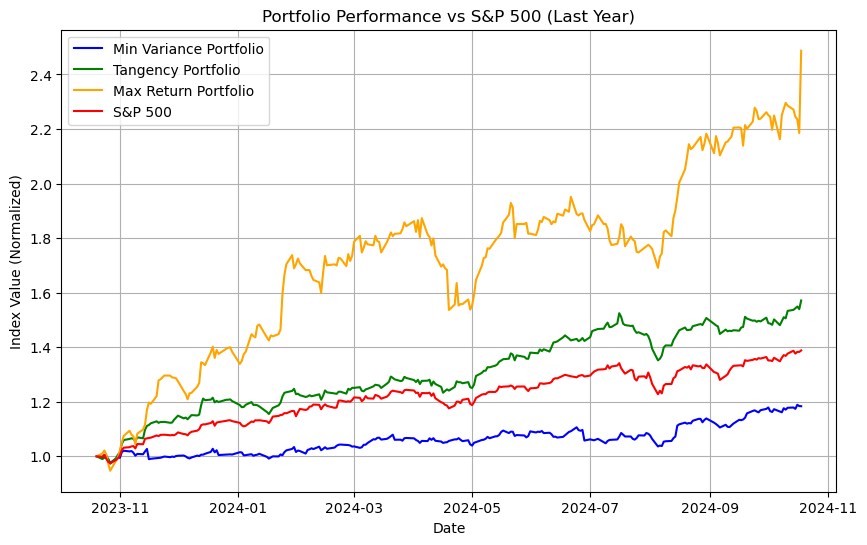

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial investment amount
initial_investment = 500000

# Define the expanded list of 50 stocks and the benchmark
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 
          'XOM', 'BAC', 'KO', 'DIS', 'PFE', 'CSCO', 'NFLX', 'BA', 'NKE', 'C', 
          'INTC', 'IBM', 'NVDA', 'ADBE', 'PYPL', 'MA', 'MRK', 'PEP', 'MCD', 'ABT', 'CRM',
          'ORCL', 'CVX', 'T', 'MDT', 'HON', 'GE', 'MMM', 'CAT', 'LOW', 'LMT', 
          'UNH', 'HD', 'TXN', 'GS', 'AXP', 'SBUX', 'UPS', 'FDX', 'TGT']
benchmark = '^GSPC'  # S&P 500 index

# Define the three portfolio weights manually
min_var_weights = {
    "AAPL": 0.0000, "MSFT": 0.0355, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0227, "JNJ": 0.0000, "WMT": 0.2179, "PG": 0.0000,
    "XOM": 0.2209, "BAC": 0.0000, "KO": 0.0131, "DIS": 0.0000, "PFE": 0.0934,
    "CSCO": 0.1536, "NFLX": 0.0000, "BA": 0.0000, "NKE": 0.1854, "C": 0.0576,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 0.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

tangency_weights = {
    "AAPL": 0.2647, "MSFT": 0.0000, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0000, "JNJ": 0.0000, "WMT": 0.0000, "PG": 0.0092,
    "XOM": 0.0000, "BAC": 0.4268, "KO": 0.0912, "DIS": 0.0000, "PFE": 0.0000,
    "CSCO": 0.0000, "NFLX": 0.1782, "BA": 0.0000, "NKE": 0.0298, "C": 0.0000,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 0.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

max_return_weights = {
    "AAPL": 0.0000, "MSFT": 0.0000, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0000, "JNJ": 0.0000, "WMT": 0.0000, "PG": 0.0000,
    "XOM": 0.0000, "BAC": 0.0000, "KO": 0.0000, "DIS": 0.0000, "PFE": 0.0000,
    "CSCO": 0.0000, "NFLX": 1.0000, "BA": 0.0000, "NKE": 0.0000, "C": 0.0000,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 1.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

# Download data for the last year for all stocks and the benchmark
data = yf.download(stocks + [benchmark], period="1y")['Adj Close']

# Calculate daily returns for each stock
daily_returns = data.pct_change().dropna()

# Calculate portfolio returns for each portfolio
min_var_portfolio_returns = (daily_returns[stocks] * pd.Series(min_var_weights)).sum(axis=1)
tangency_portfolio_returns = (daily_returns[stocks] * pd.Series(tangency_weights)).sum(axis=1)
max_return_portfolio_returns = (daily_returns[stocks] * pd.Series(max_return_weights)).sum(axis=1)

# Calculate cumulative portfolio value over time for each portfolio
min_var_portfolio_value = (1 + min_var_portfolio_returns).cumprod() * initial_investment
tangency_portfolio_value = (1 + tangency_portfolio_returns).cumprod() * initial_investment
max_return_portfolio_value = (1 + max_return_portfolio_returns).cumprod() * initial_investment

# Calculate cumulative benchmark value
benchmark_value = (1 + daily_returns[benchmark]).cumprod() * initial_investment

# Normalize the portfolio values and benchmark to start at the same value
min_var_portfolio_index = min_var_portfolio_value / min_var_portfolio_value.iloc[0]
tangency_portfolio_index = tangency_portfolio_value / tangency_portfolio_value.iloc[0]
max_return_portfolio_index = max_return_portfolio_value / max_return_portfolio_value.iloc[0]
benchmark_index = benchmark_value / benchmark_value.iloc[0]

# Plot the portfolio indices vs S&P 500 index
plt.figure(figsize=(10, 6))
plt.plot(min_var_portfolio_index, label="Min Variance Portfolio", color="blue")
plt.plot(tangency_portfolio_index, label="Tangency Portfolio", color="green")
plt.plot(max_return_portfolio_index, label="Max Return Portfolio", color="orange")
plt.plot(benchmark_index, label="S&P 500", color="red")
plt.title("Portfolio Performance vs S&P 500 (Last Year)")
plt.xlabel("Date")
plt.ylabel("Index Value (Normalized)")
plt.legend()
plt.grid(True)
plt.show()



[*********************100%***********************]  51 of 51 completed


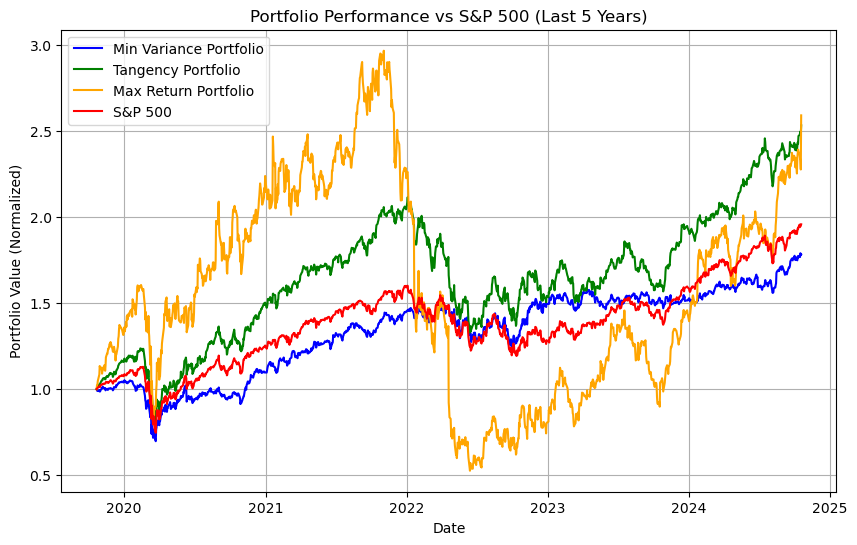

In [98]:
### 5yrs back in time
# Initial investment amount
initial_investment = 500000

# Define the expanded list of 50 stocks and the benchmark
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JPM', 'V', 'JNJ', 'WMT', 'PG', 
          'XOM', 'BAC', 'KO', 'DIS', 'PFE', 'CSCO', 'NFLX', 'BA', 'NKE', 'C', 
          'INTC', 'IBM', 'NVDA', 'ADBE', 'PYPL', 'MA', 'MRK', 'PEP', 'MCD', 'ABT', 'CRM',
          'ORCL', 'CVX', 'T', 'MDT', 'HON', 'GE', 'MMM', 'CAT', 'LOW', 'LMT', 
          'UNH', 'HD', 'TXN', 'GS', 'AXP', 'SBUX', 'UPS', 'FDX', 'TGT']
benchmark = '^GSPC'  # S&P 500 index

# Define the three portfolio weights manually
min_var_weights = {
    "AAPL": 0.0000, "MSFT": 0.0355, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0227, "JNJ": 0.0000, "WMT": 0.2179, "PG": 0.0000,
    "XOM": 0.2209, "BAC": 0.0000, "KO": 0.0131, "DIS": 0.0000, "PFE": 0.0934,
    "CSCO": 0.1536, "NFLX": 0.0000, "BA": 0.0000, "NKE": 0.1854, "C": 0.0576,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 0.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

tangency_weights = {
    "AAPL": 0.2647, "MSFT": 0.0000, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0000, "JNJ": 0.0000, "WMT": 0.0000, "PG": 0.0092,
    "XOM": 0.0000, "BAC": 0.4268, "KO": 0.0912, "DIS": 0.0000, "PFE": 0.0000,
    "CSCO": 0.0000, "NFLX": 0.1782, "BA": 0.0000, "NKE": 0.0298, "C": 0.0000,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 0.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

max_return_weights = {
    "AAPL": 0.0000, "MSFT": 0.0000, "GOOGL": 0.0000, "AMZN": 0.0000, "TSLA": 0.0000,
    "JPM": 0.0000, "V": 0.0000, "JNJ": 0.0000, "WMT": 0.0000, "PG": 0.0000,
    "XOM": 0.0000, "BAC": 0.0000, "KO": 0.0000, "DIS": 0.0000, "PFE": 0.0000,
    "CSCO": 0.0000, "NFLX": 1.0000, "BA": 0.0000, "NKE": 0.0000, "C": 0.0000,
    "INTC": 0.0000, "IBM": 0.0000, "NVDA": 0.0000, "ADBE": 0.0000, "PYPL": 0.0000, 
    "MA": 0.0000, "MRK": 0.0000, "PEP": 0.0000, "MCD": 0.0000, "ABT": 0.0000,
    "CRM": 0.0000, "ORCL": 0.0000, "CVX": 0.0000, "T": 0.0000, "MDT": 1.0000,
    "HON": 0.0000, "GE": 0.0000, "MMM": 0.0000, "CAT": 0.0000, "LOW": 0.0000,
    "LMT": 0.0000, "UNH": 0.0000, "HD": 0.0000, "TXN": 0.0000, "GS": 0.0000,
    "AXP": 0.0000, "SBUX": 0.0000, "UPS": 0.0000, "FDX": 0.0000, "TGT": 0.0000
}

# Download data for the last 5 years for all stocks and the benchmark
data = yf.download(stocks + [benchmark], period="5y")['Adj Close']

# Calculate daily returns for each stock
daily_returns = data.pct_change().dropna()

# Calculate portfolio returns for each portfolio
min_var_portfolio_returns = (daily_returns[stocks] * pd.Series(min_var_weights)).sum(axis=1)
tangency_portfolio_returns = (daily_returns[stocks] * pd.Series(tangency_weights)).sum(axis=1)
max_return_portfolio_returns = (daily_returns[stocks] * pd.Series(max_return_weights)).sum(axis=1)

# Calculate cumulative portfolio value over time for each portfolio
min_var_portfolio_value = (1 + min_var_portfolio_returns).cumprod() * initial_investment
tangency_portfolio_value = (1 + tangency_portfolio_returns).cumprod() * initial_investment
max_return_portfolio_value = (1 + max_return_portfolio_returns).cumprod() * initial_investment

# Normalize the portfolio values to start at the same point 5 years ago
min_var_portfolio_index = min_var_portfolio_value / min_var_portfolio_value.iloc[0]
tangency_portfolio_index = tangency_portfolio_value / tangency_portfolio_value.iloc[0]
max_return_portfolio_index = max_return_portfolio_value / max_return_portfolio_value.iloc[0]

# Normalize the S&P 500 index to start at the price 5 years ago
benchmark_value = (1 + daily_returns[benchmark]).cumprod() * initial_investment
benchmark_index = benchmark_value / benchmark_value.iloc[0]

# Plot the portfolio indices vs S&P 500 index
plt.figure(figsize=(10, 6))
plt.plot(min_var_portfolio_index, label="Min Variance Portfolio", color="blue")
plt.plot(tangency_portfolio_index, label="Tangency Portfolio", color="green")
plt.plot(max_return_portfolio_index, label="Max Return Portfolio", color="orange")
plt.plot(benchmark_index, label="S&P 500", color="red")
plt.title("Portfolio Performance vs S&P 500 (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (Normalized)")
plt.legend()
plt.grid(True)
plt.show()